In [ ]:
# !pip install keras
# %pip install tensorflow

In [ ]:
# Import
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import backend

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from PIL import Image
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
# Image Paths
input_image_path = 'bobst_lib.jpeg'
style_image_path = 'vecbuildfinal.jpeg'
output_image_path = 'output.png'
transformed_image_path = 'transformed.png'

In [ ]:
# Hyperparamters
ITERATIONS = 5
IMAGE_WIDTH, IMAGE_HEIGHT = 500, 500
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
CHANNELS = 3
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

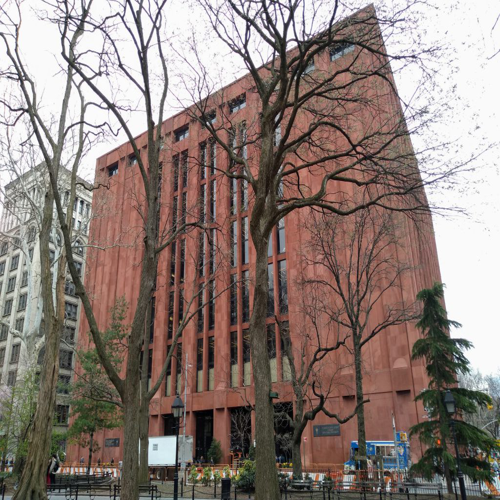

In [ ]:
# target to be transformed
input_image = Image.open(input_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image

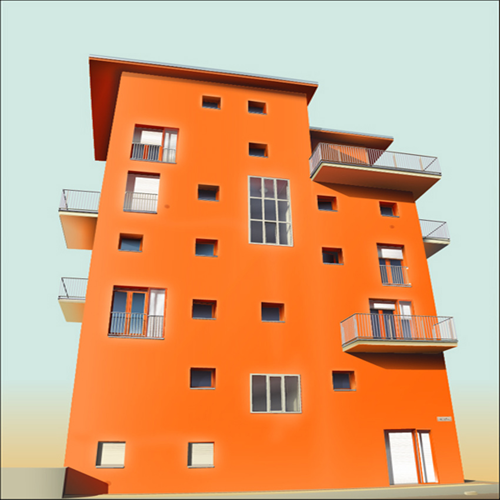

In [ ]:
# style image
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image

In [ ]:
# preprocess the input image and add to keras backend
input_image_arr = np.asarray(input_image, dtype='float32')
input_image_arr = np.expand_dims(input_image_arr, axis=0)
input_image_arr[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_arr[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_arr[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_arr = input_image_arr[:, :, :, ::-1]
input_image = backend.variable(input_image_arr)


In [ ]:
# preprocess the style image and add to keras backend
style_image_arr = np.asarray(style_image, dtype='float32')
style_image_arr = np.expand_dims(style_image_arr, axis=0)
style_image_arr[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_arr[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_arr[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_arr = style_image_arr[:, :, :, ::-1]
style_image = backend.variable(style_image_arr)

In [ ]:
# Model design
transformed_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print(input_image_arr.shape, style_image.shape, transformed_image.shape)

# create the VGG16 CNN model using the input, style, and transformed images
model = VGG16(input_tensor=backend.concatenate([input_image, style_image, transformed_image], axis=0), include_top=False)

(1, 500, 500, 3) (1, 500, 500, 3) (1, 500, 500, 3)


In [ ]:
# model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(3, 500, 500, 3)]        0         
                                                                 
 block1_conv1 (Conv2D)       (3, 500, 500, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 500, 500, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 250, 250, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 250, 250, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 250, 250, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (3, 125, 125, 128)        0     

In [ ]:
def content_loss(model, content_layer_name, weight):
    """ 
    Calculates distance between the input and output images while trying to 
    preserve the input image's content.

    Input:
        - model: VGG16 model loaded with the stacked dataset
        - content_layer_name: content layer of choice from VGG16 model
        - weight: weight for the content loss

    Returns:
        - l2_loss: weighted loss value using the content layer from VGG16 model (dtype=float)
    """
    # initialize content layer features
    content_layer_features = None
    # find matching content layer
    for idx, layer in enumerate(model.layers):
        if layer.name == content_layer_name:
            # add the corresponding features
            content_layer_features = model.layers[idx].output
            break
    #print(content_layer_features)
    image_idx = 0
    combination_idx = 2
    # extract the input image features
    image_features = content_layer_features[image_idx,:,:,:]
    # extract the output image features
    combination_features = content_layer_features[combination_idx,:,:,:]
    # calculate the weighted loss
    l2_loss = weight * backend.sum(backend.square(combination_features - image_features))
    
    return l2_loss

# initialize the loss
loss = backend.variable(0.)
# increment the loss with the content loss value
loss = loss + content_loss(model,"block2_conv2", CONTENT_WEIGHT)
#loss

In [ ]:
def style_loss(model, style_layers):
    """ 
    Calculates distance between the style and output images while trying to 
    preserve the style image's style content.

    Input:
        - model: VGG16 model loaded with the stacked dataset
        - style_layers: a list of strings, representing style layers of VGG16 model

    Returns:
        - loss: weighted loss value using all specified style layers from VGG16 model (dtype=float)
    """
    # initialize the loss
    loss = 0
    # loop over all style layers specified
    for style_layer_name in style_layers:
        layer_style_loss = 0
        for idx, layer in enumerate(model.layers):
            if layer.name == style_layer_name:
                style_layer_features = model.layers[idx].output

                # extract style and combination features
                style_features = style_layer_features[1, :, :, :]
                combination_features = style_layer_features[2, :, :, :]

                # create gram matrix of combination style
                features = backend.batch_flatten(backend.permute_dimensions(style_features, (2, 0, 1)))
                style_features_gram = backend.dot(features, backend.transpose(features))

                # create gram matrix of combination input
                features = backend.batch_flatten(backend.permute_dimensions(combination_features, (2, 0, 1)))
                combination_features_gram = backend.dot(features, backend.transpose(features))

                # square the difference between style and combination
                sum_sq_diff = backend.sum(backend.square(style_features_gram - combination_features_gram))

                # set size and denominator 
                size = IMAGE_HEIGHT * IMAGE_WIDTH
                denominator = 4. * (CHANNELS ** 2) * (size ** 2)
                # final layer style loss
                layer_style_loss = sum_sq_diff / denominator

                # append the loss for each weighted style_layer_loss 
                weight = STYLE_WEIGHT / len(style_layers)
                loss += weight * layer_style_loss
                continue

    return loss

# specify style layers
#style_layers = ["block1_conv2", "block2_conv2", "block3_conv3"]#, "block4_conv3"]#, "block5_conv3"]
#style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv2", "block4_conv2", "block5_conv2"]
# append the style loss to the overall loss
loss += style_loss(model, style_layers)

In [ ]:
def total_variation_loss(combo_img, loss_factor, weight):
    """ 
    Calculates loss value to be applied as regularization.spatial smoothness to denoise the output image.

    Input:
        - model: VGG16 model loaded with the stacked dataset
        - loss_factor: loss factor to applied as exponent for sum of squared loss
        - weight: weight for total variation loss

    Returns:
        - loss: weighted loss value using the content layer from VGG16 model (dtype=float)
    """
    loss = 0
    # combination data with height and width limited
    h_w_lim = combo_img[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :]
    # combination data that doesn't include first element of 2nd dimension
    h_shifted = combo_img[:, 1:, :IMAGE_WIDTH-1, :]
    # combination data that doesn't include first element of 3rd dimension
    w_shifted = combo_img[:, :IMAGE_HEIGHT-1, 1:, :]
    # squaring the difference
    squared_1 = backend.square(h_w_lim - h_shifted)
    squared_2 = backend.square(h_w_lim - w_shifted)
    # add both squared differences
    sum_squares = squared_1 + squared_2
    # final loss by sum of exponent of loss factor
    loss = backend.sum(backend.pow(sum_squares, loss_factor))
    # weighted loss
    loss = weight * loss
    return loss
# append the total_variation_loss to the overall loss
loss += total_variation_loss(transformed_image, TOTAL_VARIATION_LOSS_FACTOR, TOTAL_VARIATION_WEIGHT)

outputs = [loss]
# calculate the gradients using transformed image
outputs += backend.gradients(loss, transformed_image)

In [ ]:
class Evaluator:

  def __init__(self):
    self._gradients = None # updated through calculate_loss_and_gradients function
  
  def calculate_loss_and_gradients(self, x, combined_image, outputs):
    """
    Calculates loss and gradients

    Input:
        - x: prev guess which is updated in each iteration
        - combined_image: image that is transformed based on input image and style image
        - outputs: loss from VGG16 model

    Returns:
        - loss: weighted loss value using the content layer from VGG16 model (dtype=float)
        - gradients: gradients of the loss function
    """
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combined_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    self._gradients = gradients
    return loss, gradients
  
  def loss(self, x):
    loss, gradients = self.calculate_loss_and_gradients(x, transformed_image, outputs)
    self._gradients = gradients
    return loss
  
  def gradients(self, x):
    return self._gradients

In [ ]:
evaluator = Evaluator()
ITERATIONS = 10 #5

x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

# optimize using L-BFGS algorithm.
for i in range(0, ITERATIONS):
  x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
  print("Iteration: %d with loss: %f" % (i, loss))

Iteration: 0 with loss: 90117357568.000000
Iteration: 1 with loss: 57588858880.000000
Iteration: 2 with loss: 43830231040.000000
Iteration: 3 with loss: 36979560448.000000
Iteration: 4 with loss: 33074706432.000000
Iteration: 5 with loss: 30508695552.000000
Iteration: 6 with loss: 28851335168.000000
Iteration: 7 with loss: 27736301568.000000
Iteration: 8 with loss: 26938859520.000000
Iteration: 9 with loss: 26337867776.000000


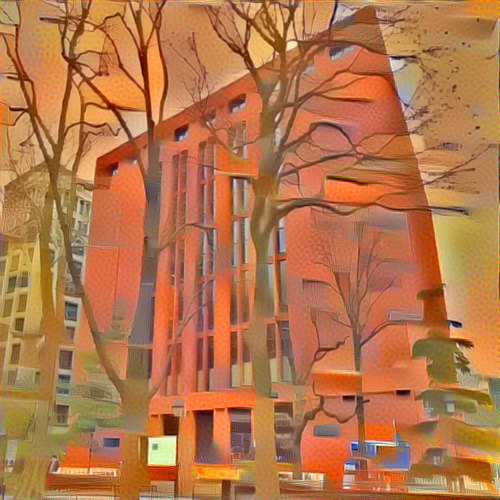

In [ ]:
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image